<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/18_Febrero_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo CSV cargado exitosamente.
Puntos: 301 | fs: 1000.0000 Hz
f_min: 3.3223 Hz | f_max: 498.3389 Hz
Filtro: 60 Hz a 250 Hz


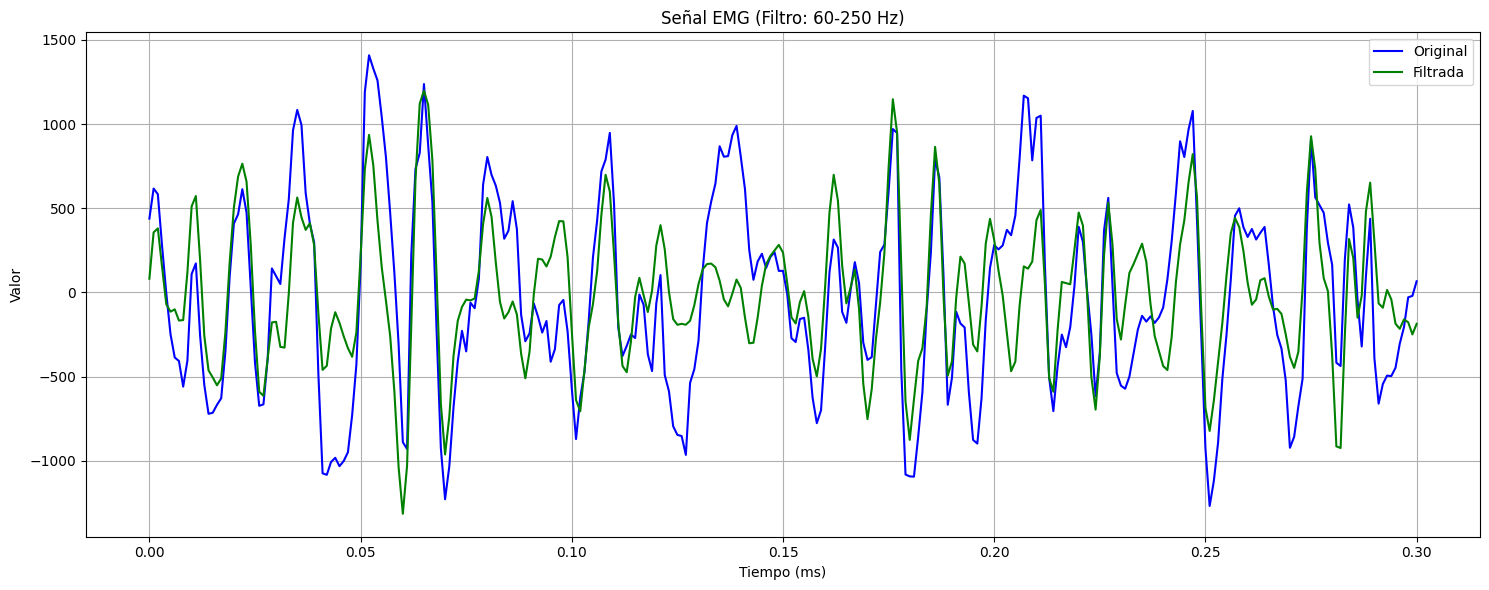

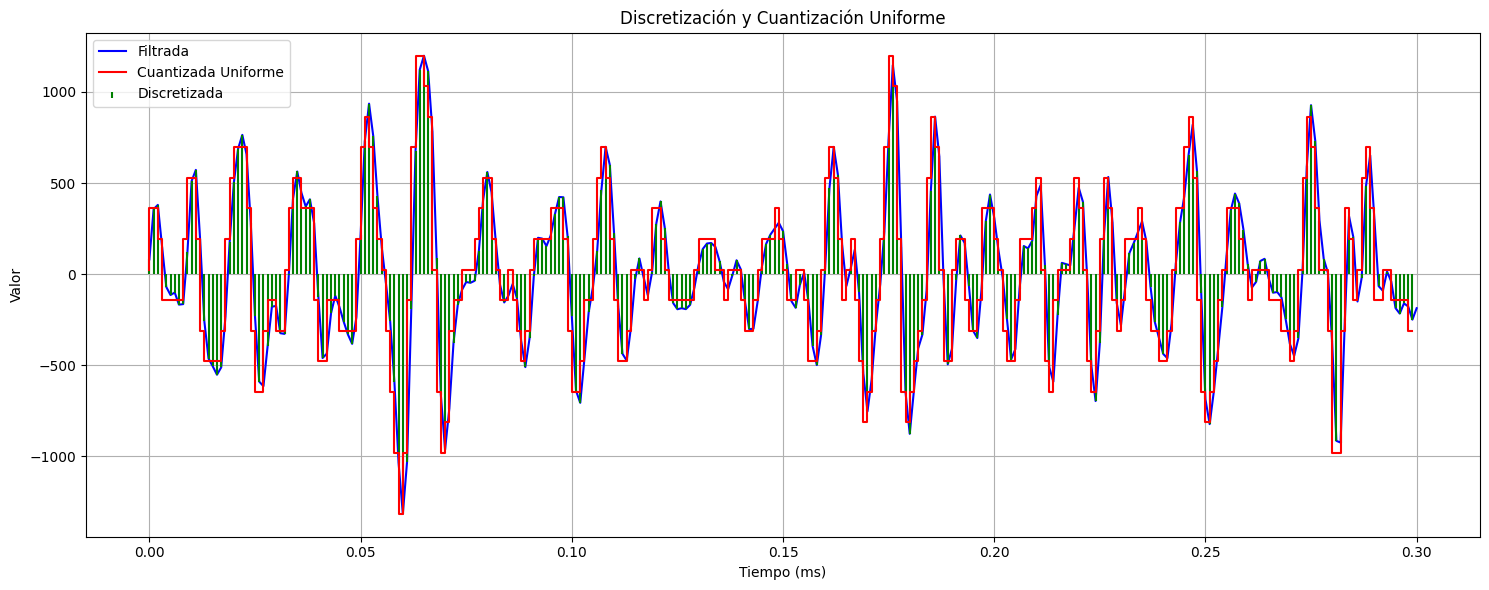

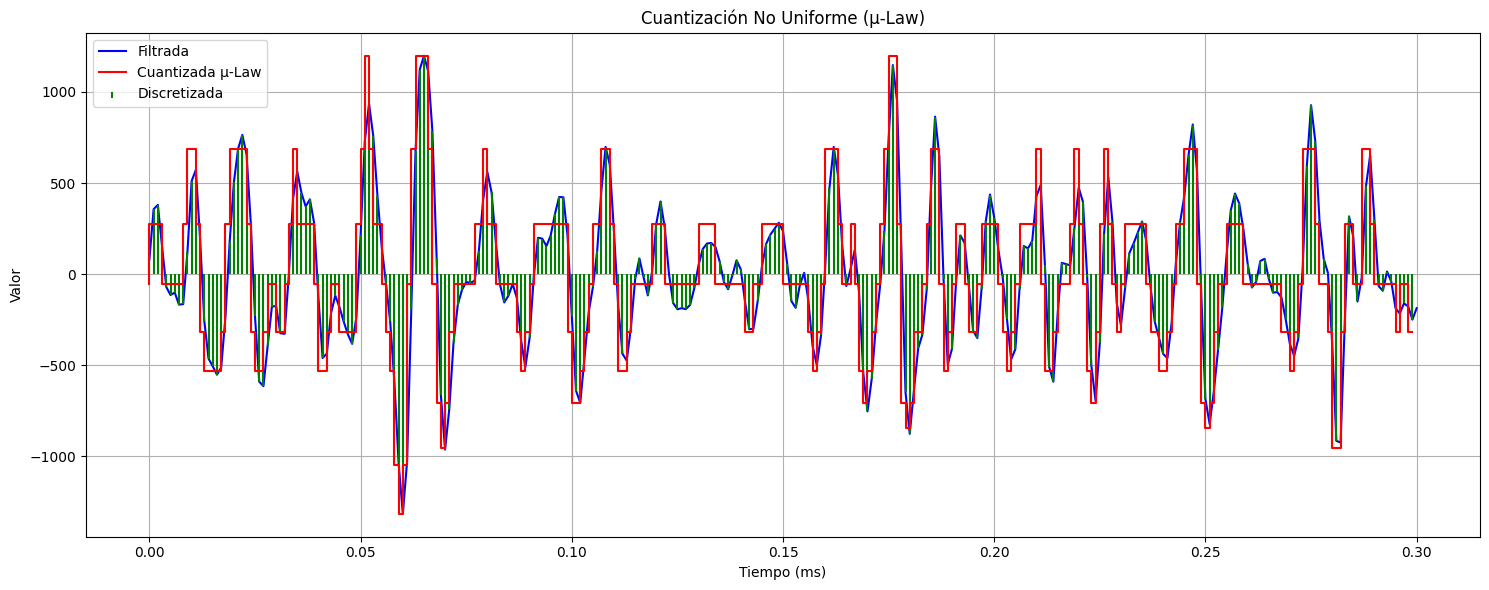

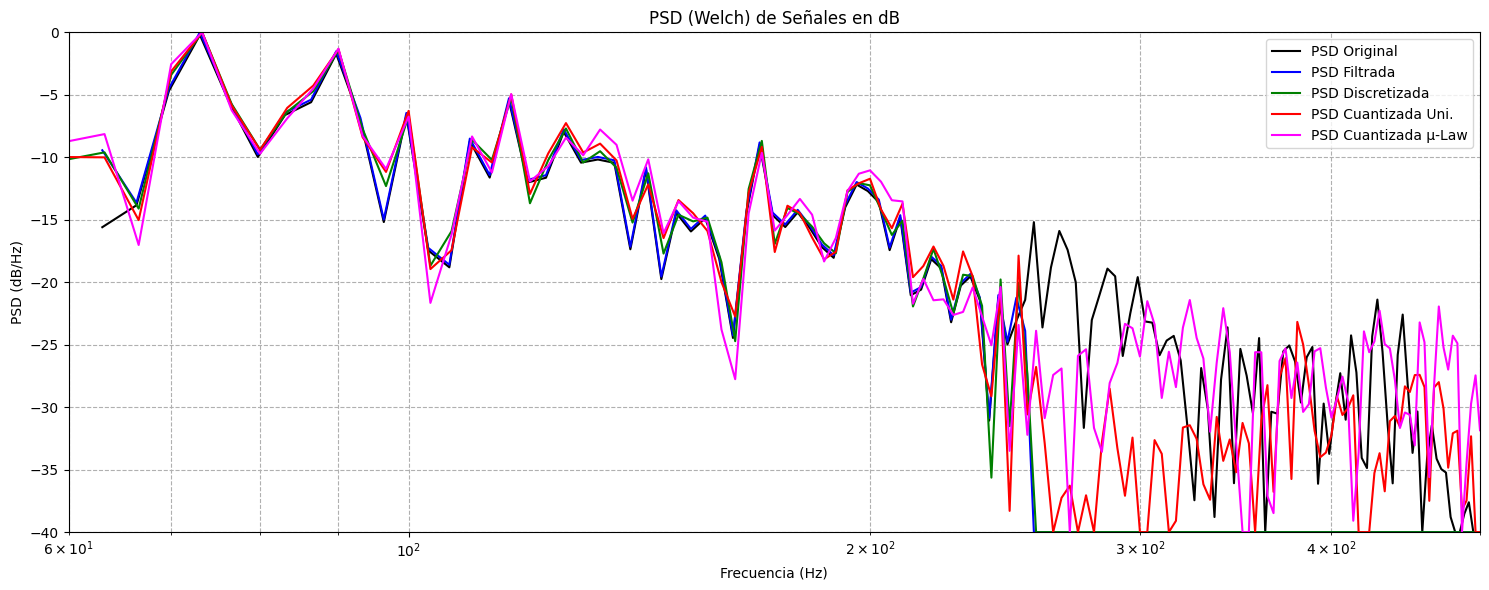

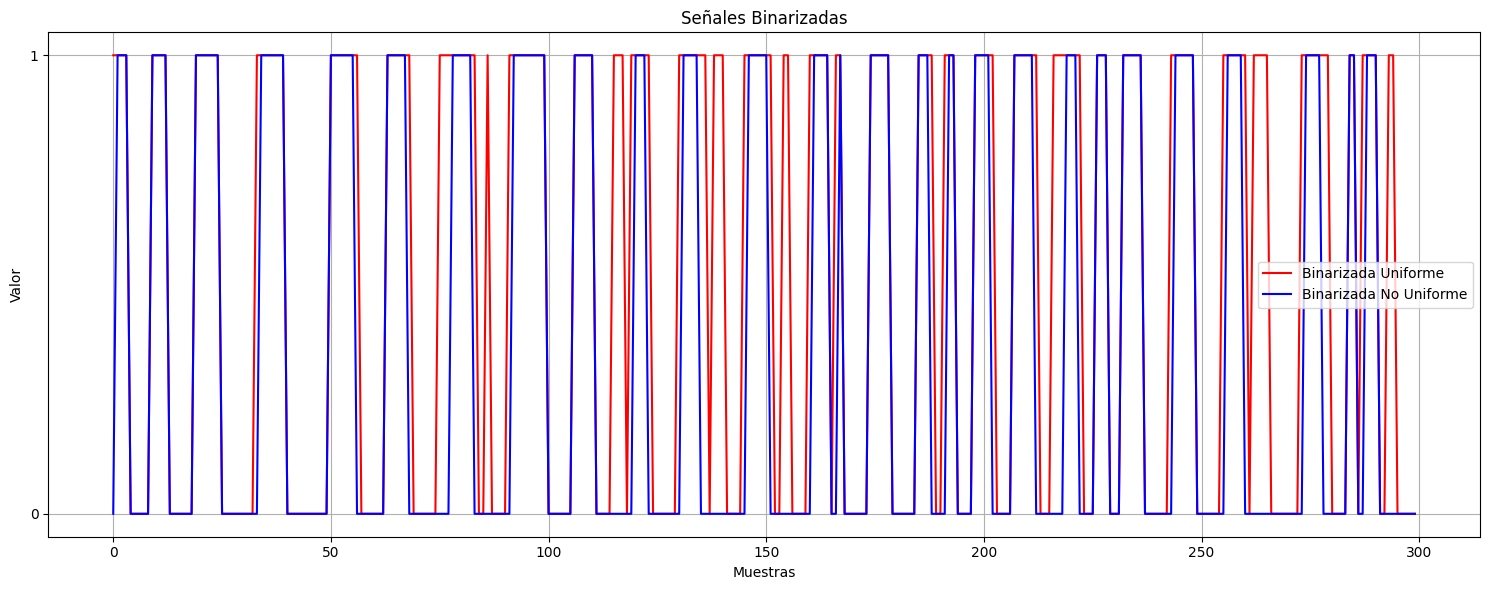

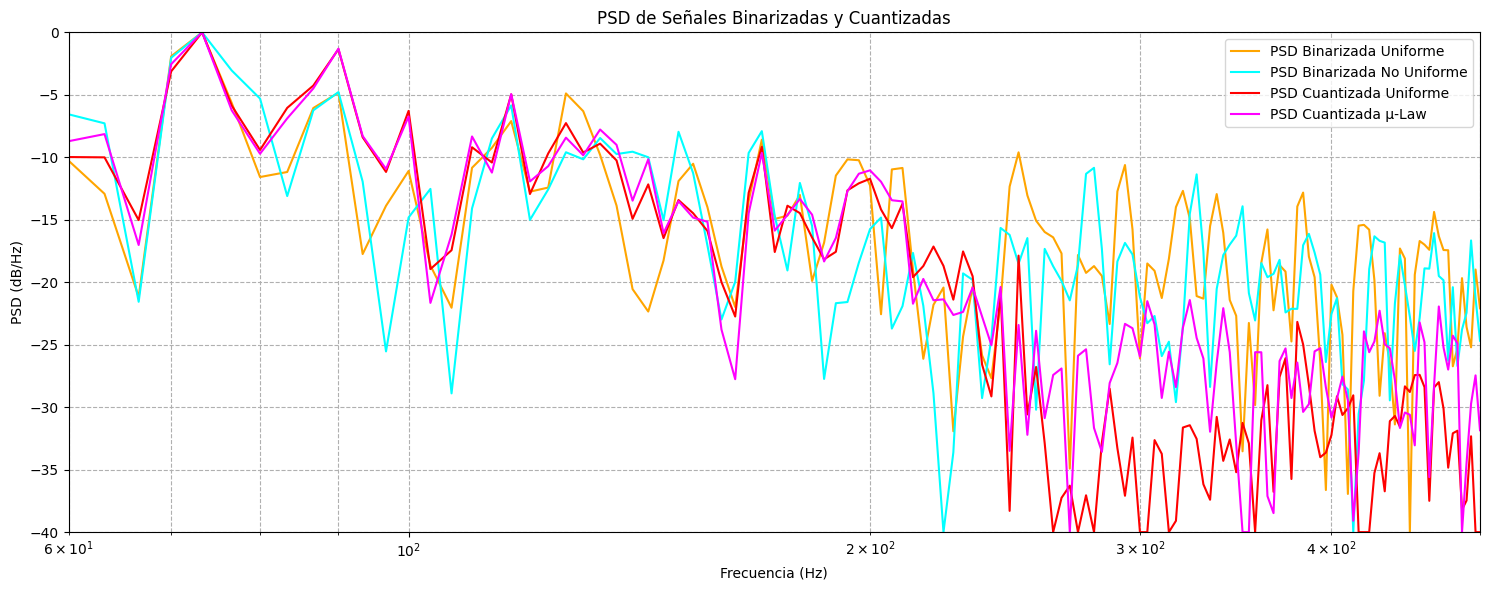

In [19]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import welch
from google.colab import drive

# Definición de las clases (TimeDomainProcessor, DiscreteQuantProcessor, PSDProcessor)
# Asegúrate de copiar aquí el código de las clases que has proporcionado.

class TimeDomainProcessor:
    """
    Carga, filtra y analiza la señal en el dominio del tiempo.
    """
    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        self.csv_path = csv_path
        self.tiempo_a_graficar = tiempo_a_graficar
        self.tiempo = self.señal = None
        self.tiempo_filtrado = self.señal_filtrada = None
        self.N_filtrado = self.T = self.fs = None
        self.y_f = self.frecuencias = None
        self.f_min = self.f_max = None
        self.y_f_filtrado = self.señal_filtrada_freq = None

    def mount_drive(self):
        """Monta el drive de Google Colab."""
        drive.mount('/content/drive')

    def load_and_filter(self):
        """Carga el CSV, filtra la señal y calcula parámetros básicos."""
        try:
            datos = pd.read_csv(self.csv_path)
            print("Archivo CSV cargado exitosamente.")
        except Exception as e:
            print(f"Error al cargar el archivo CSV: {e}")
            exit()
        if 'Tiempo (ms)' in datos.columns and 'Datos Columna 2' in datos.columns:
            datos['Tiempo (ms)'] = pd.to_numeric(datos['Tiempo (ms)'], errors='coerce')
            self.tiempo = datos['Tiempo (ms)'].values
            self.señal = datos['Datos Columna 2'].values
            mask = self.tiempo <= self.tiempo_a_graficar
            self.tiempo_filtrado, self.señal_filtrada = self.tiempo[mask], self.señal[mask]
            self.N_filtrado = len(self.señal_filtrada)
            self.T = np.mean(np.diff(self.tiempo_filtrado))
            self.fs = 1 / self.T
            print(f"Puntos: {self.N_filtrado} | fs: {self.fs:.4f} Hz")
        else:
            print("Error: El CSV no contiene las columnas requeridas.")
            exit()

    def compute_fft(self):
        """Calcula la FFT de la señal filtrada."""
        self.y_f = fft(self.señal_filtrada)
        self.frecuencias = fftfreq(self.N_filtrado, d=self.T)
        positive_freqs = np.abs(self.frecuencias[self.frecuencias > 0])
        print(f"f_min: {np.min(positive_freqs):.4f} Hz | f_max: {np.max(positive_freqs):.4f} Hz")

    def apply_bandpass_filter(self, f_min, f_max):
        """
        Aplica un filtro pasabanda en el dominio de la frecuencia.

        Parameters:
            f_min (float): Frecuencia mínima.
            f_max (float): Frecuencia máxima.
        """
        self.f_min, self.f_max = f_min, f_max
        filtro = (np.abs(self.frecuencias) >= f_min) & (np.abs(self.frecuencias) <= f_max)
        self.y_f_filtrado = self.y_f * filtro
        self.señal_filtrada_freq = np.real(ifft(self.y_f_filtrado))
        print(f"Filtro: {f_min} Hz a {f_max} Hz")

    def plot_time_domain(self):
        """Grafica la señal original y la señal filtrada."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada, 'b-', label='Original')
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'g-', label='Filtrada')
        plt.title(f'Señal EMG (Filtro: {self.f_min}-{self.f_max} Hz)')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

class DiscreteQuantProcessor:
    """
    Realiza la discretización y cuantización (uniforme y μ‑Law) de la señal.
    """
    def __init__(self, tiempo_filtrado, señal_filtrada_freq):
        self.tiempo_filtrado = tiempo_filtrado
        self.señal_filtrada_freq = señal_filtrada_freq

    def discretize_signal(self, sampling_rate=1000):
        """Discretiza la señal por interpolación."""
        t_discreto = np.arange(self.tiempo_filtrado[0], self.tiempo_filtrado[-1], 1/sampling_rate)
        return t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq)

    @staticmethod
    def quantize_uniform(x, q_min, q_max, q_level):
        """Cuantización uniforme de la señal."""
        xn = (x - q_min) * (q_level - 1) / (q_max - q_min)
        return np.round(np.clip(xn, 0, q_level - 1)) * (q_max - q_min) / (q_level - 1) + q_min

    @staticmethod
    def quantize_mu_law(signal, L=16, mu=255, x_min=None, x_max=None):
        """Cuantización no uniforme usando la ley μ‑Law."""
        x_min = signal.min() if x_min is None else x_min
        x_max = signal.max() if x_max is None else x_max
        x_norm = (signal - x_min) / (x_max - x_min)
        companded = np.log1p(mu * x_norm) / np.log1p(mu)
        q_companded = np.round(companded * (L - 1)) / (L - 1)
        return (np.expm1(q_companded * np.log1p(mu)) / mu) * (x_max - x_min) + x_min

    def plot_discretized_quantized(self, t_discreto, señal_discreta, señal_quant_uniform):
        """Grafica la señal discretizada y cuantizada uniformemente."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, señal_discreta, linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.step(t_discreto, señal_quant_uniform, 'r-', label='Cuantizada Uniforme')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Discretización y Cuantización Uniforme')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_quantized_mu(self, t_discreto, señal_quant_mu):
        """Grafica la señal cuantizada con μ‑Law."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Filtrada')
        plt.stem(t_discreto, np.interp(t_discreto, self.tiempo_filtrado, self.señal_filtrada_freq),
                  linefmt='g-', markerfmt=' ', basefmt=' ', label='Discretizada')
        plt.step(t_discreto, señal_quant_mu, 'r-', label='Cuantizada μ‑Law')
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Valor')
        plt.title('Cuantización No Uniforme (μ‑Law)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

class PSDProcessor:
    """
    Calcula y grafica la densidad espectral de potencia (PSD) usando el método de Welch.
    """
    def __init__(self, fs, f_min):
        self.fs, self.f_min = fs, f_min

    def plot_psd(self, señal_original, señal_filtrada, señal_discreta, señal_qunif, señal_qmu, eps=1e-12):
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        f1, psd1 = calc_psd(señal_original)
        f2, psd2 = calc_psd(señal_filtrada)
        f3, psd3 = calc_psd(señal_discreta)
        f4, psd4 = calc_psd(señal_qunif)
        f5, psd5 = calc_psd(señal_qmu)

        plt.figure(figsize=(15, 6))
        for f, psd, label, col in zip([f1, f2, f3, f4, f5],
                                      [psd1, psd2, psd3, psd4, psd5],
                                      ['Original', 'Filtrada', 'Discretizada', 'Cuantizada Uni.', 'Cuantizada μ‑Law'],
                                      ['black', 'blue', 'green', 'red', 'magenta']):
            plt.plot(f[f>=self.f_min], psd[f>=self.f_min], color=col, label=f'PSD {label}')
        plt.title('PSD (Welch) de Señales en dB')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_binarized_psd(self, señal_binarizada_uni, señal_binarizada_no_uni, señal_qunif, señal_qmu, eps=1e-12):
        """
        Grafica la PSD de las señales binarizadas y las señales cuantizadas.

        Parameters:
            señal_binarizada_uni (array): Señal binarizada uniforme.
            señal_binarizada_no_uni (array): Señal binarizada no uniforme.
            señal_qunif (array): Señal cuantizada uniforme.
            señal_qmu (array): Señal cuantizada no uniforme.
        """
        def calc_psd(signal):
            n = min(1024, len(signal))
            f, psd = welch(signal, self.fs, nperseg=n)
            psd_db = 10 * np.log10(psd + eps)
            return f, np.clip(psd_db - psd_db.max(), -40, 0)

        f_binarizada_uni, psd_binarizada_uni = calc_psd(señal_binarizada_uni)
        f_binarizada_no_uni, psd_binarizada_no_uni = calc_psd(señal_binarizada_no_uni)
        f_qunif, psd_qunif = calc_psd(señal_qunif)
        f_qmu, psd_qmu = calc_psd(señal_qmu)

        plt.figure(figsize=(15, 6))
        plt.plot(f_binarizada_uni[f_binarizada_uni >= self.f_min], psd_binarizada_uni[f_binarizada_uni >= self.f_min], color='orange', label='PSD Binarizada Uniforme')
        plt.plot(f_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], psd_binarizada_no_uni[f_binarizada_no_uni >= self.f_min], color='cyan', label='PSD Binarizada No Uniforme')
        plt.plot(f_qunif[f_qunif >= self.f_min], psd_qunif[f_qunif >= self.f_min], color='red', label='PSD Cuantizada Uniforme')
        plt.plot(f_qmu[f_qmu >= self.f_min], psd_qmu[f_qmu >= self.f_min], color='magenta', label='PSD Cuantizada μ-Law')

        plt.title('PSD de Señales Binarizadas y Cuantizadas')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Nueva clase para Binarización
class Binarization:
    """
    Clase para binarizar la señal cuantizada.
    """
    def __init__(self, señal_cuantizada, señal_cuantizada_no_uniforme):
        self.señal_cuantizada = señal_cuantizada
        self.señal_cuantizada_no_uniforme = señal_cuantizada_no_uniforme
        self.señal_binarizada_uni = None
        self.señal_binarizada_no_uni = None

    def binarize(self, threshold=0):
        """
        Binariza la señal cuantizada usando un umbral.

        Parameters:
            threshold (float): Umbral para la binarización.
        """
        self.señal_binarizada_uni = np.where(self.señal_cuantizada > threshold, 1, 0)
        self.señal_binarizada_no_uni = np.where(self.señal_cuantizada_no_uniforme > threshold, 1, 0)

    def plot_binarized_signals(self):
        """Grafica las señales binarizadas."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.señal_binarizada_uni, 'r-', label='Binarizada Uniforme')
        plt.plot(self.señal_binarizada_no_uni, 'b-', label='Binarizada No Uniforme')
        plt.title('Señales Binarizadas')
        plt.xlabel('Muestras')
        plt.ylabel('Valor')
        plt.yticks([0, 1])
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


# =============================================================================
# Ejecución principal
# =============================================================================
if __name__ == "__main__":
    # Ruta del archivo CSV
    csv_path = "/content/drive/MyDrive/Signal Theory/Running_Columna_2_Tiempo.csv"

    # Crear instancia de TimeDomainProcessor
    tdp = TimeDomainProcessor(csv_path, tiempo_a_graficar=0.3)
    tdp.mount_drive()
    tdp.load_and_filter()

    # Calcular FFT antes de aplicar el filtro
    tdp.compute_fft()  # Asegúrate de llamar a esta función

    # Definir frecuencias para el filtro
    f_min = 60  # Cambia según sea necesario
    f_max = 250  # Cambia según sea necesario
    tdp.apply_bandpass_filter(f_min, f_max)
    tdp.plot_time_domain()  # Gráfica 1

    # Crear instancia de DiscreteQuantProcessor
    dq = DiscreteQuantProcessor(tdp.tiempo_filtrado, tdp.señal_filtrada_freq)
    t_discreto, señal_discreta = dq.discretize_signal(sampling_rate=1000)
    num_bits, levels = 4, 2 ** 4
    q_min, q_max = señal_discreta.min(), señal_discreta.max()
    señal_qunif = dq.quantize_uniform(señal_discreta, q_min, q_max, levels)
    señal_qmu = dq.quantize_mu_law(señal_discreta, L=levels, mu=25)

    dq.plot_discretized_quantized(t_discreto, señal_discreta, señal_qunif)  # Gráfica 2
    dq.plot_quantized_mu(t_discreto, señal_qmu)  # Gráfica 3

    # Crear instancia de PSDProcessor
    psd_processor = PSDProcessor(tdp.fs, f_min)
    psd_processor.plot_psd(tdp.señal_filtrada, tdp.señal_filtrada_freq,
                            señal_discreta, señal_qunif, señal_qmu)  # Gráfica 4

    # Crear instancia de Binarization
    binarization = Binarization(señal_qunif, señal_qmu)  # Usar la señal cuantizada uniforme y no uniforme
    binarization.binarize(threshold=0)  # Binarizar con umbral 0
    binarization.plot_binarized_signals()  # Gráfica de las señales binarizadas

    # Graficar la PSD de las señales binarizadas y cuantizadas
    psd_processor.plot_binarized_psd(binarization.señal_binarizada_uni,
                                      binarization.señal_binarizada_no_uni,
                                      señal_qunif, señal_qmu)  # Nueva gráfica